# Solving Cantilever Beams Using DeepXDE Library

A uniform cantilever beam has bending modulus $EI$ and length $L$. It has a uniform distributed weight $c$, with a concentrated force $P$ acting on the free end.

## Differential Equation:
$$EI\frac{d^2v}{dx^2} = \frac{c}{2}(L-x)^2 - P(L-x)$$

## Boundary Conditions:
$$\frac{dv}{dx}(0) = 0 \quad and \quad v(0) = 0$$

## Analytical Solution:
$$EIv(x) = \frac{cx^4}{24} + \frac{(P-cL)}{6}x^3 + \frac{(cL^2-2PL)}{4}x^2$$

## 1. Setup

In [1]:
# !pip install deepxde

In [2]:
import deepxde as dde
import numpy as np
import tensorflow as tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# define parameters
E = 1.0 # Modulus of Elasticity
I = 1.0 # Moment of Inertia
c = 1.0 # Load Distribution
L = 1.0 # Length of Cantilever
P = 1.0 # Force on end

In [4]:
# geometry
geom = dde.geometry.Interval(0,L)

## 2. Creating Model

In [5]:
# differential equation
def pde(x, v):
    d2v_dx2 = dde.grad.hessian(v, x, i=0, j=0)
    return (d2v_dx2)-((1/(E*I))*(0.5*c*(L-x)**2-P*(L-x)))

In [6]:
# boundary conditions
def boundary_left(x, _): 
    return np.isclose(x[0], 0)
bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left)  # v(0) = 0
bc2 = dde.NeumannBC(geom, lambda x: 0, boundary_left)  # v'(0) = 0

In [7]:
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2],
    num_domain=254,
    num_boundary=2,
    anchors=None
)

In [8]:
net = dde.maps.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")

model = dde.Model(data, net) # Define the model 

## 3. Training the Model

In [9]:
model.compile("adam", lr=1e-3) 
losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.032849 s


'compile' took 0.265726 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.19e-01, 0.00e+00, 1.15e-01]    [1.19e-01, 0.00e+00, 1.15e-01]    []  
1000      [2.64e-04, 5.48e-09, 5.49e-08]    [2.64e-04, 5.48e-09, 5.49e-08]    []  
2000      [2.20e-04, 2.53e-09, 5.23e-08]    [2.20e-04, 2.53e-09, 5.23e-08]    []  
3000      [1.70e-04, 1.76e-09, 3.03e-08]    [1.70e-04, 1.76e-09, 3.03e-08]    []  
4000      [1.14e-04, 8.45e-10, 1.36e-08]    [1.14e-04, 8.45e-10, 1.36e-08]    []  
5000      [5.65e-05, 2.26e-10, 4.06e-09]    [5.65e-05, 2.26e-10, 4.06e-09]    []  
6000      [7.94e-06, 9.51e-12, 5.07e-10]    [7.94e-06, 9.51e-12, 5.07e-10]    []  
7000      [3.79e-06, 1.56e-09, 8.25e-11]    [3.79e-06, 1.56e-09, 8.25e-11]    []  
8000      [3.30e-06, 4.44e-08, 1.16e-07]    [3.30e-06, 4.44e-08, 1.16e-07]    []  
9000      [2.86e-06, 2.32e-07, 3

## 4. Visualize

In [14]:
import matplotlib.pyplot as plt

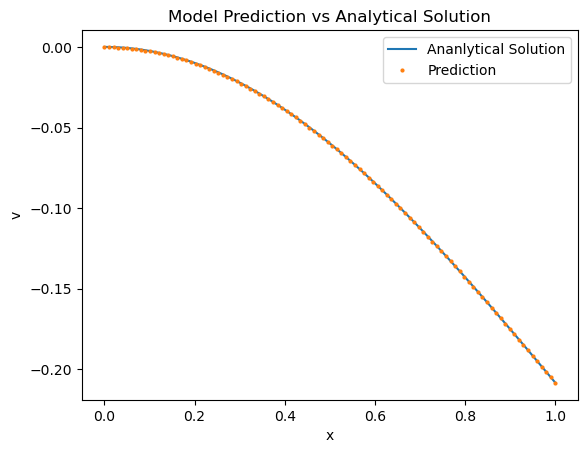

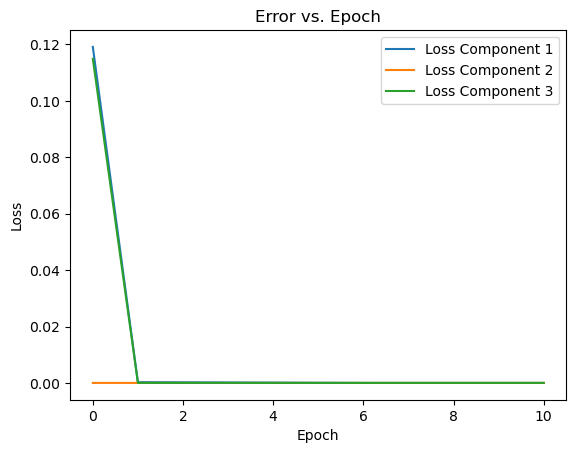

In [24]:
X = geom.uniform_points(100, True) 
v_pred = model.predict(X) 

v_exact = (((c*X**4)/24)+(((P-(c*L))*X**3)/6)+((((c*L**2)-(2*P*L))*X**2)/4))/(E*I)

plt.plot(X, v_exact, label="Ananlytical Solution")
plt.plot(X, v_pred, 'o', label="Prediction", markersize=2) 
plt.xlabel("x") 
plt.ylabel("v") 
plt.title("Model Prediction vs Analytical Solution") 
plt.legend() 
plt.show()

# Extracting and plotting the individual loss components 
losses = losshistory.loss_train 
epochs = range(len(losses)) 
plt.figure() 
for i, loss_component in enumerate(zip(*losses)): 
    plt.plot(epochs, loss_component, label=f"Loss Component {i + 1}") 

plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.title("Error vs. Epoch") 
plt.legend() 
plt.show()